In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import scipy.stats as stats
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV

In this second part we try to solve the previous problem in a simplier way. 

## Approach

1. **Binary Classification**:
    - Reframe the problem from predicting a range of immersion levels to a binary classification task, classifying each instance as either "bad" or "good" immersion.

2. **Maintain Problem Structure**:
    - The structure and approach to solving the problem will remain the same. This involves data preprocessing, feature selection, model training, and evaluation, but with the new binary classification objective.

3. **Differences between the two projecs**:
    - To implement this change, I have created a new notebook for the new binary classification task. This notebook follow the same methodological approach as before but it is adapted to the binary classification problem.

By transforming the classification problem in this manner, I aim to simplify the task and potentially improve the model's ability to learn from the data.

Note that **previous comments have been delated**, new comments are made just where it is possible to appriciate any diffrence.

# TASK 1 : Data Exploration and Preprocessing

# TASK 1.1 
*Load the ”vr dataset” dataset.*


In [51]:
#Download the dataset
dataframe = pd.read_csv('vr_dataset.csv', delimiter=',')

DATA = dataframe.copy()

###########################################################################

# from the dataset keep only the observations that have attribute VRHeadset = 'PlayStation VR' NO RELEVANT DIFFERENCE
# dataframe = dataframe[dataframe['VRHeadset'] == 'PlayStation VR']

#Split the target variable in bad or good
dataframe['ImmersionLevel'] = dataframe['ImmersionLevel'].apply(lambda x: 1 if x >= 2 else 0)

# Balance the dataset
dataframe = dataframe.sample(frac=1)
bad = dataframe[dataframe['ImmersionLevel'] == 0]
good = dataframe[dataframe['ImmersionLevel'] == 1][:len(bad)]
dataframe = pd.concat([bad, good])
#########################################################################


#Get the shape of the dataset
(N_records, N_features) = dataframe.shape

#Print the first 5 rows of the dataset
print(f'\n\nFIRST 5 ROWS OF THE DATASET\n\n{dataframe.head().round(2)}')

#Print general description of the dataset
print(f'\n\nDESCRIPTION OF THE DATASET\n\n{dataframe.describe().round(2)}') 



FIRST 5 ROWS OF THE DATASET

     UserID  Age  Gender       VRHeadset  Duration  MotionSickness  \
254     255   32    Male     Oculus Rift     59.14               9   
559     560   42  Female  PlayStation VR     30.58               8   
749     750   43   Other        HTC Vive     10.65               1   
490     491   38   Other     Oculus Rift     53.18               4   
221     222   38   Other  PlayStation VR     45.74              10   

     ImmersionLevel  
254               0  
559               0  
749               0  
490               0  
221               0  


DESCRIPTION OF THE DATASET

        UserID    Age  Duration  MotionSickness  ImmersionLevel
count   404.00  404.0    404.00          404.00           404.0
mean    485.32   39.5     32.23            5.56             0.5
std     280.05   11.6     15.79            2.85             0.5
min       2.00   18.0      5.04            1.00             0.0
25%     247.25   30.0     19.29            3.00             0.0
50

# TASK 1.2 
*Handle any missing values or outliers, if present.*

In [52]:
#Check for missing values 
stats = []
for col in dataframe.columns:
    stats.append([col, dataframe[col].nunique(), dataframe[col].isnull().sum(), dataframe[col].dtype])
    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Missing_values', 'Data_type'])
print(f'\n\nSTATISTICS OF THE DATASET\n\n{tabulate(stats_df, headers="keys", tablefmt="pretty")}')



STATISTICS OF THE DATASET

+---+----------------+---------------+----------------+-----------+
|   |    Feature     | Unique_values | Missing_values | Data_type |
+---+----------------+---------------+----------------+-----------+
| 0 |     UserID     |      404      |       0        |   int64   |
| 1 |      Age       |      43       |       0        |   int64   |
| 2 |     Gender     |       3       |       0        |  object   |
| 3 |   VRHeadset    |       3       |       0        |  object   |
| 4 |    Duration    |      404      |       0        |  float64  |
| 5 | MotionSickness |      10       |       0        |   int64   |
| 6 | ImmersionLevel |       2       |       0        |   int64   |
+---+----------------+---------------+----------------+-----------+


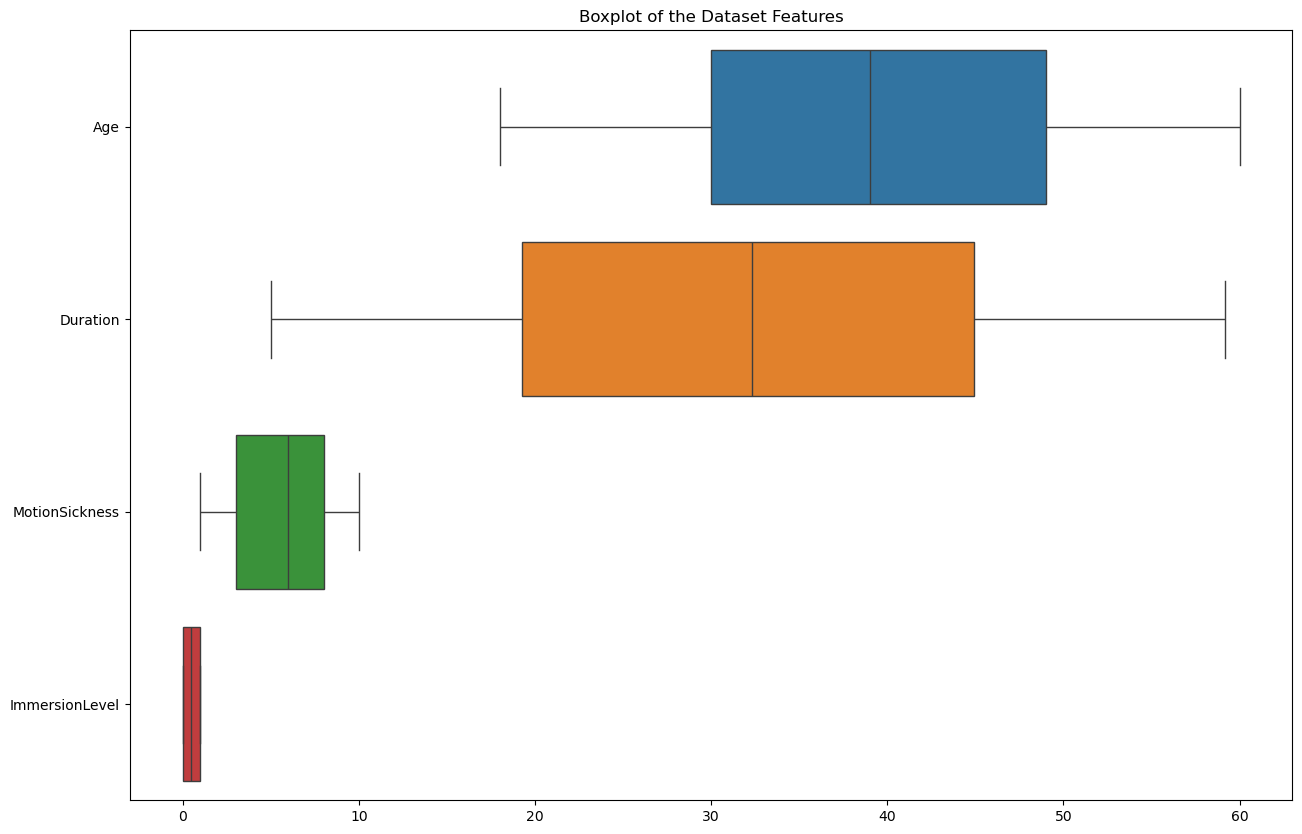

In [53]:
#Check for outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=dataframe.drop('UserID', axis=1), orient='h')
plt.title('Boxplot of the Dataset Features')
plt.show()

# Task 1.2

*Visualize the distribution of the ”Age” and ”VRHeadset variables using appropriate plots (e.g., histograms scatter plots)*

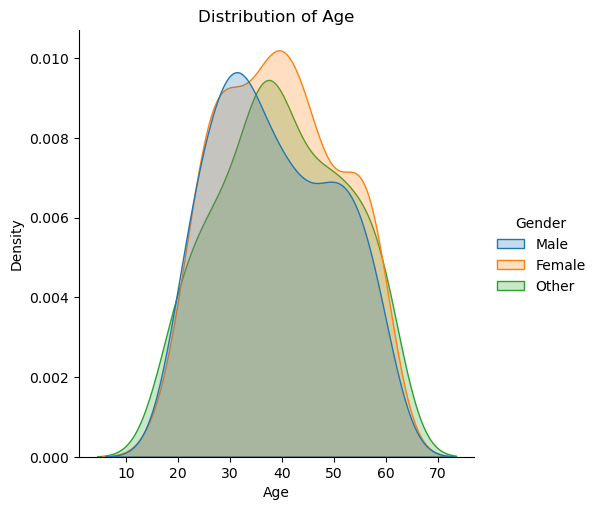

In [54]:
#Visualize the distribution of the "Age" variable
sns.displot(dataframe, x="Age", hue="Gender", kind="kde",fill=True, legend=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

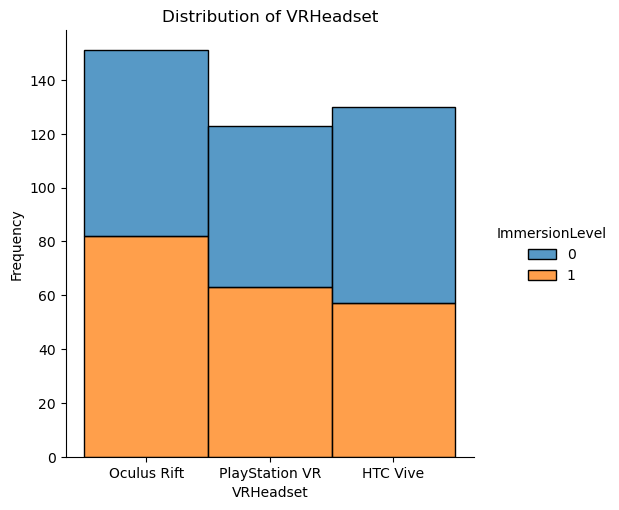

In [55]:
sns.displot(dataframe, x="VRHeadset", hue="ImmersionLevel", multiple="stack", kind="hist", legend=True)   
plt.title('Distribution of VRHeadset')
plt.xlabel('VRHeadset')
plt.ylabel('Frequency')
plt.show()

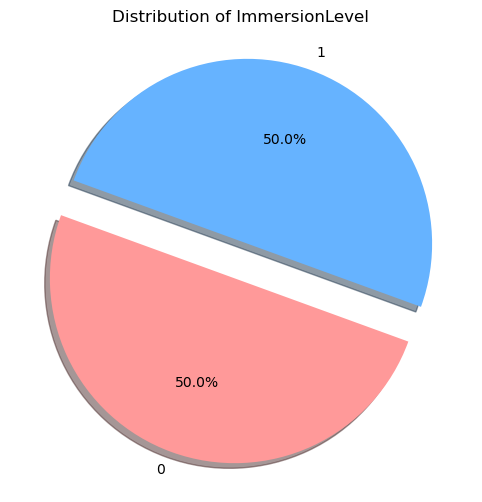

In [56]:
plt.figure(figsize=(10, 6))
plt.pie(dataframe['ImmersionLevel'].value_counts(), labels=dataframe['ImmersionLevel'].value_counts().index, autopct='%1.1f%%', shadow=True, startangle=160, explode=(0.1, 0.1), colors=['#ff9999','#66b3ff'])
plt.title('Distribution of ImmersionLevel')
plt.show()

# TASK 2 : Feature Selection and Engineering

# TASK 2.1

*Identify the relevant features from the dataset that can potentially influence immersion level prediction.*


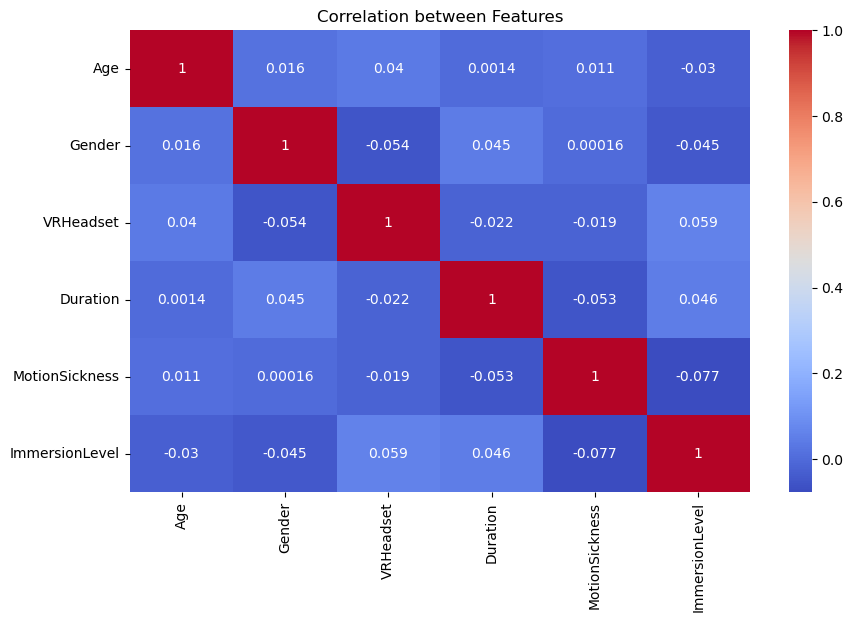

In [57]:
# Convert categorical variables into numerical variables
df = dataframe.copy()
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['VRHeadset'] = label_encoder.fit_transform(df['VRHeadset'])

# Visualize the correlation between features
correlation_matrix = df.drop(['UserID'], axis=1).corr(),
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop(['UserID'], axis=1).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between Features')
plt.show()


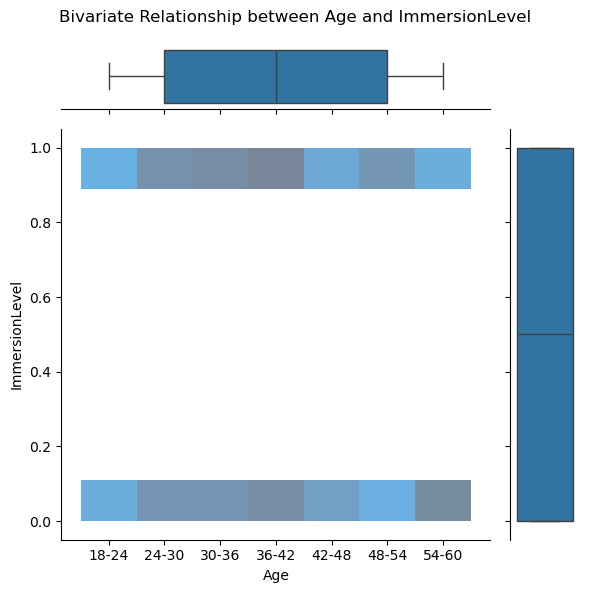

In [58]:
# Group the age in intervals 
df = dataframe.copy()
df['Age'] = pd.cut(df['Age'], bins=[18, 24, 30, 36, 42, 48, 54, 60], labels=['18-24', '24-30', '30-36', '36-42', '42-48', '48-54', '54-60'])

# Visualize the Bivariate relationship between the "Age" and "ImmersionLevel" variables
g = sns.JointGrid(data=df, x="Age", y="ImmersionLevel")
g.plot_joint(sns.histplot, bins=9, alpha=0.7)
g.plot_marginals(sns.boxplot)
plt.xlabel('Age')
plt.ylabel('ImmersionLevel')
plt.suptitle('Bivariate Relationship between Age and ImmersionLevel')
plt.tight_layout()
plt.show()

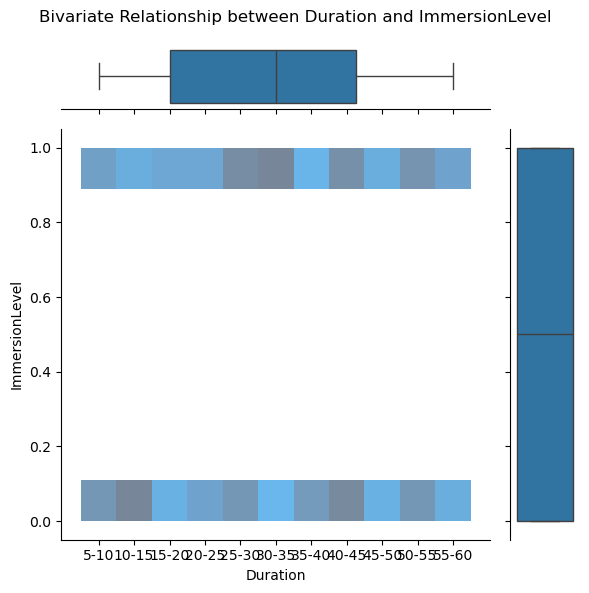

In [59]:
# Group the duration in intervals
df = dataframe.copy()
df['Duration'] = pd.cut(df['Duration'], bins=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], labels=['5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60']) 

# Visualize the Bivariate relationship between the "Duration" and "ImmersionLevel" variables
g = sns.JointGrid(data=df, x="Duration", y="ImmersionLevel", space=0)
g.plot_joint(sns.histplot, bins=9, alpha=0.7)
g.plot_marginals(sns.boxplot)
plt.xlabel('Duration')
plt.ylabel('ImmersionLevel')
plt.suptitle('Bivariate Relationship between Duration and ImmersionLevel')
plt.tight_layout()
plt.show()

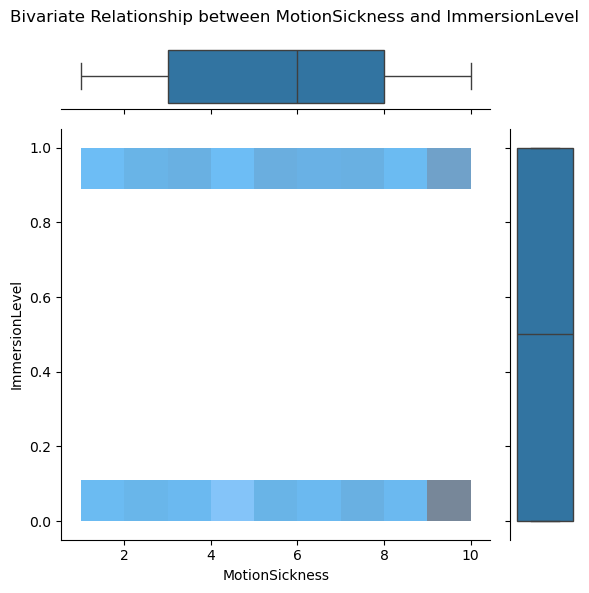

In [60]:
# Visualize the Bivariate relationship between the "MotionSickness" and "ImmersionLevel" variables
g = sns.JointGrid(data=dataframe, x="MotionSickness", y="ImmersionLevel", space=0)
g.plot_joint(sns.histplot, bins=9, alpha=0.7)
g.plot_marginals(sns.boxplot)
plt.xlabel('MotionSickness')
plt.ylabel('ImmersionLevel')
plt.suptitle('Bivariate Relationship between MotionSickness and ImmersionLevel')
plt.tight_layout()
plt.show()

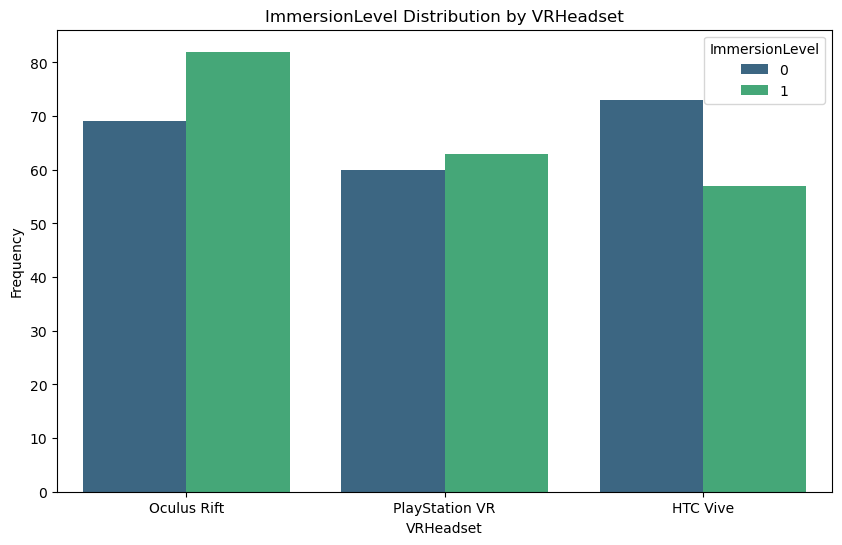

In [61]:
# Countplot of the "ImmersionLevel" variable with respect to VRHeadset
plt.figure(figsize=(10, 6))
sns.countplot(data=dataframe, x='VRHeadset', hue='ImmersionLevel', palette='viridis')
plt.title('ImmersionLevel Distribution by VRHeadset')
plt.xlabel('VRHeadset')
plt.ylabel('Frequency')
plt.show()

HTC Vive is prone to bad Imersion level and PlayStation VR is prone to good immersion level.

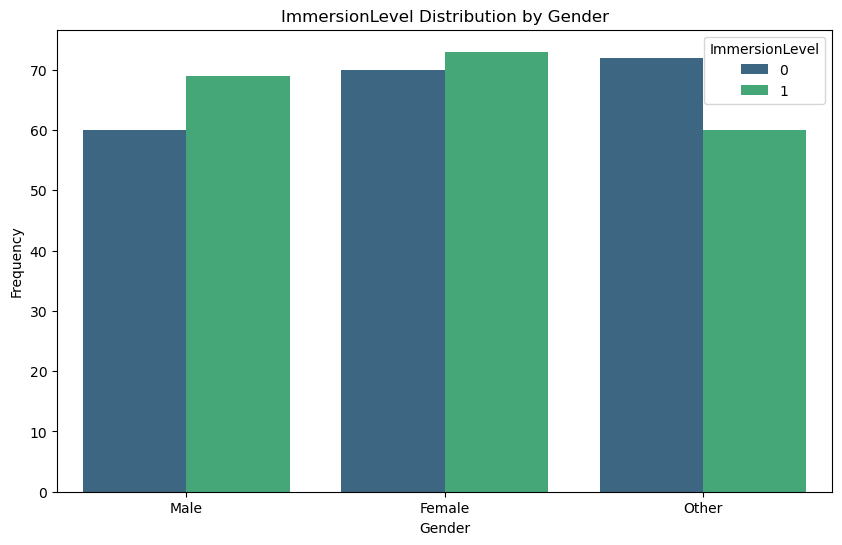

In [62]:
# Countplot of the "ImmersionLevel" variable with respect to the Gender
plt.figure(figsize=(10, 6))
sns.countplot(data=dataframe, x='Gender', hue='ImmersionLevel', palette='viridis')
plt.title('ImmersionLevel Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()

We can see that males are more prone to good immersion level, Other instead are more prone to bad immersion level.

# TASK 2.2

*Perform feature engineering, if necessary, such as scaling or transforming features.*

In [63]:
# The selected features are: Age, Duration, MotionSickness, Note that these features are categorical
features = ['Age', 'Duration', 'MotionSickness', 'VRHeadset', 'Gender']

# The target feature is ImmersionLevel
target = 'ImmersionLevel'

# Split the dataset into features and target
X = dataframe[features]
y = dataframe[target]

# One-hot encode the categorical features
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [3, 4])], remainder='passthrough')

# TASK 3 : Model Development and Evaluation

# TASK 3.1-3.2

*Choose an appropriate machine learning algorithm (e.g., linear regression,decision tree regression, or random forest regression)to train the model.*

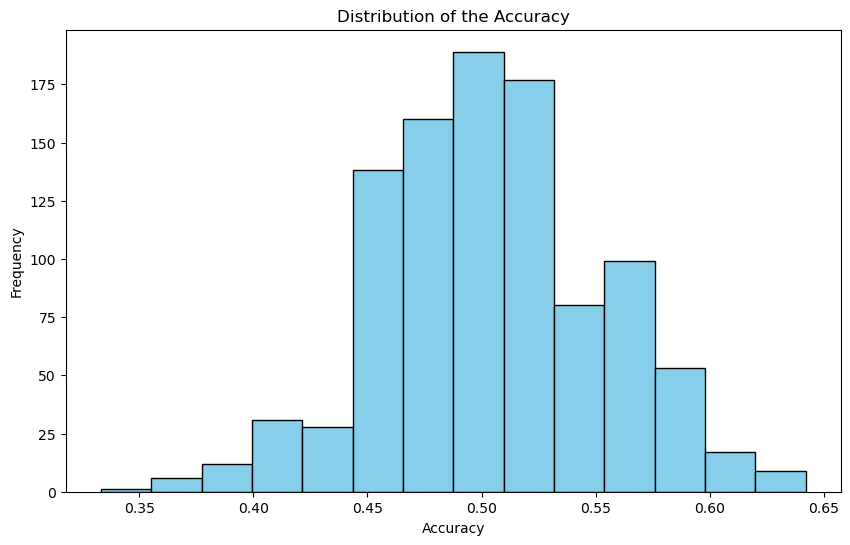


The best model parameters are the following:

The most relevant features for decision tree classifier are the following
encoder__VRHeadset_HTC Vive: 2.21%
encoder__VRHeadset_Oculus Rift: 2.30%
encoder__VRHeadset_PlayStation VR: 2.83%
encoder__Gender_Female: 2.59%
encoder__Gender_Male: 3.01%
encoder__Gender_Other: 2.58%
remainder__Age: 30.25%
remainder__Duration: 35.52%
remainder__MotionSickness: 18.71%


In [79]:
# choose a model to train among the two models, 
if True:
    rf = RandomForestClassifier()
    param_grid =param_grid = {
                            'n_estimators': [50, 100, 150],
                            'max_depth': [10, 20, 30, 40, 50],
                            'min_samples_split': [2, 5, 10],
                            'min_samples_leaf': [1, 2, 4]
                            }
else:
    rf = DecisionTreeClassifier()
    param_grid = {
                            'max_depth': [10, 20, 30, 40, 50],
                            'min_samples_split': [2, 5, 10],
                            'min_samples_leaf': [1, 2, 4]
                        }

dim = 1000
accuracy = np.zeros(dim)
models =[]
for ii in range(dim):
    # Split the dataset into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Fit the ColumnTransformer
    X_train = ct.fit_transform(X_train)
    X_test = ct.transform(X_test)

    # Store the feature names
    feature_names = ct.get_feature_names_out()

    # Predict the target variable
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Evaluate the model
    accuracy[ii] = rf.score(X_test, y_test)

    # Save the model
    models.append(rf)

# Plot the distribution of the accuracy
plt.figure(figsize=(10, 6))
plt.hist(accuracy, bins=14, color='skyblue', edgecolor='black')
plt.title('Distribution of the Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

# select the best model
best_model = models[np.argmax(accuracy)]

# Print the best model parameters
print(f'\nThe best model parameters are the following:')
rf = best_model
print(f'\nThe most relevant features for decision tree classifier are the following')
for i in range(len(feature_names)):
    print(f'{feature_names[i]}: {rf.feature_importances_[i]*100:.2f}%')


As for the first part the type of headset and the gender does not considerably affect the immersion level.

# IMPORTANT

Note that the accuracy of the model is around 52% and the variance is less important than the random predictor.

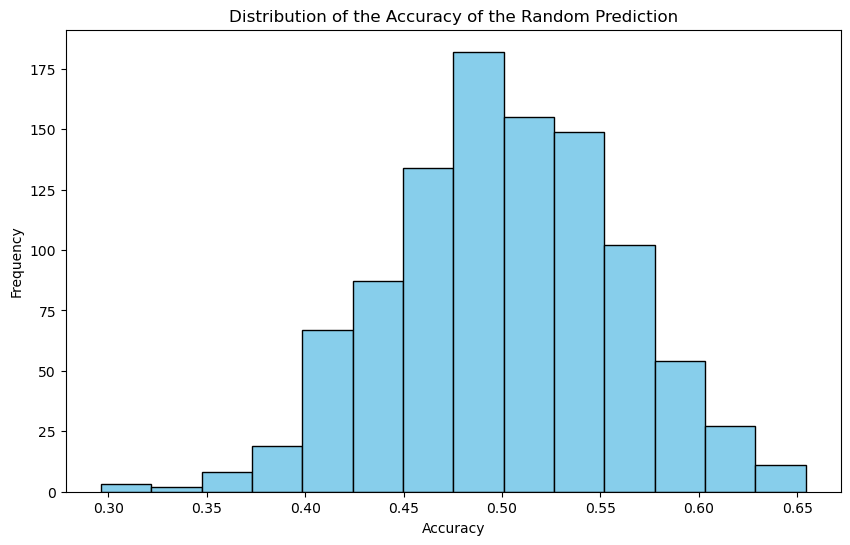

In [97]:
# Compute the accuracy of the random prediction
accuracy_random = np.zeros(dim)
for k in range(dim):
    y_pred_random = np.random.choice(y_test, len(y_test))
    
    accuracy_random[k] = rf.score(X_test, y_pred_random)
    
# Plot the distribution of the accuracy of the random prediction
plt.figure(figsize=(10, 6))
plt.hist(accuracy_random, bins=14, color='skyblue', edgecolor='black')
plt.title('Distribution of the Accuracy of the Random Prediction')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

# TASK 3.3
*Fine-tune the model, if required, by adjusting hyperparameters to improve performance.*

Let'see if optimize/tuning the model can improve its performance.

In [85]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f'\n\nBest hyperparameters: {grid_search.best_params_}')

8807.40s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8807.59s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8807.81s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8808.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds




Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


# TASK 4 : Prediction and Interpretation

# TASK 4.1

*Use the trained model to make predictions on the testing data.*

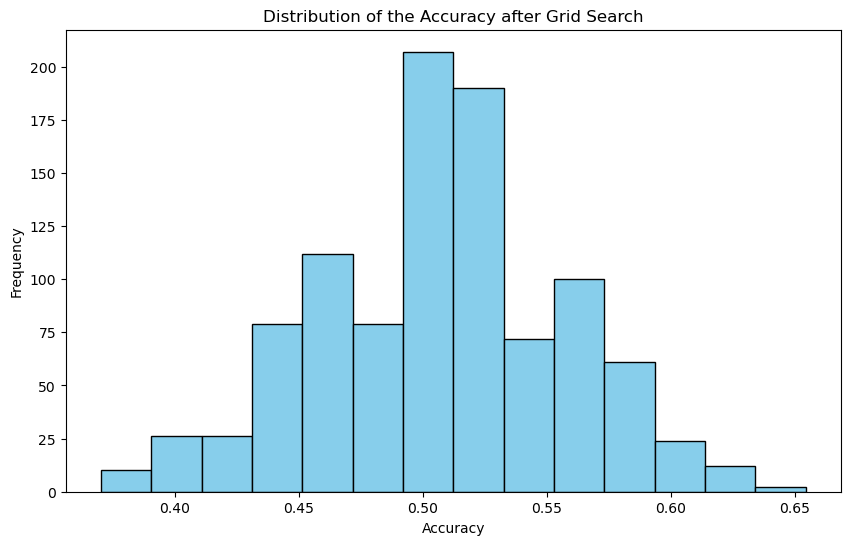

In [90]:
accuracy_tuned = np.zeros(dim)
for ii in range(dim):
    # Split the dataset into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Fit the ColumnTransformer
    X_train = ct.fit_transform(X_train)
    X_test = ct.transform(X_test)

    # Store the feature names
    feature_names = ct.get_feature_names_out()

    # Predict the target variable
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Evaluate the model
    accuracy_tuned[ii] = rf.score(X_test, y_test)

    # Save the model
    models.append(rf)

# Plot the distribution of the accuracy
plt.figure(figsize=(10, 6))
plt.hist(accuracy_tuned, bins=14, color='skyblue', edgecolor='black')
plt.title('Distribution of the Accuracy after Grid Search')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

As shown in this distribution we can appriciate a slight increase of the performances.

# TASK 4.2

*Assess the model’s performance by comparing the predicted immersion levels with the actual immersion levels.*

This task requires to perform a validation step on the model, since the generated model has no particular prediction capabilities this step is not particularly improved.

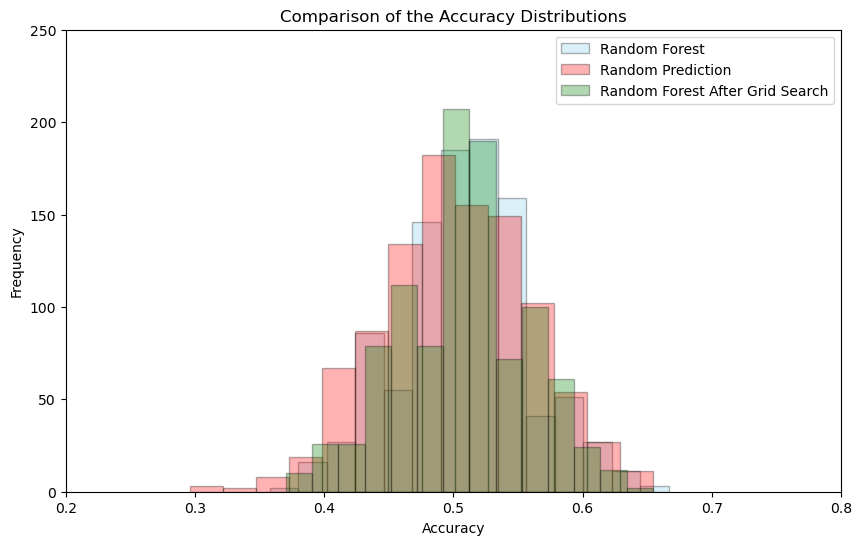

In [99]:
# plot the 3 accuracy distributions
plt.figure(figsize=(10, 6))

# Plot histograms
plt.hist(accuracy, bins=14, color='skyblue', edgecolor='black', alpha=0.3, label='Random Forest')
plt.hist(accuracy_random, bins=14, color='red', edgecolor='black', alpha=0.3, label='Random Prediction')
plt.hist(accuracy_tuned, bins=14, color='green', edgecolor='black', alpha=0.3, label='Random Forest After Grid Search')

# Set the same scale for x and y axes
plt.xlim([0.2, 0.8])  # Replace min_value and max_value with your desired range for x-axis
plt.ylim([0, 250])  # Replace min_count and max_count with your desired range for y-axis

plt.title('Comparison of the Accuracy Distributions')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.show()

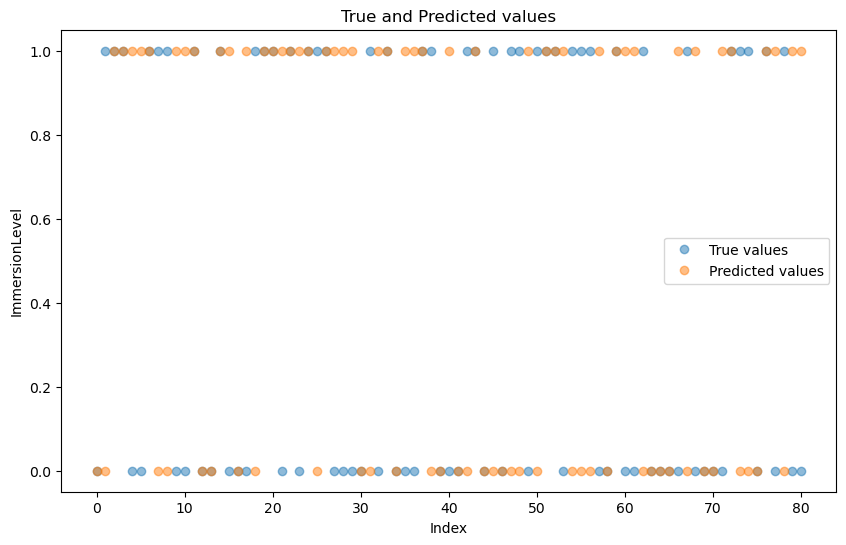

In [96]:
# plot the the predicted and the true values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, 'o', label='True values',alpha=0.5)
plt.plot(y_pred, 'o', label='Predicted values',alpha=0.5)
plt.title('True and Predicted values')
plt.xlabel('Index')
plt.ylabel('ImmersionLevel')
plt.legend()
plt.show()

# Task 4.3 : 
*Provide recommendations for future improvements or possible extensions to the project.*

# Conclusions

The developed models demonstrate **none** ability to capture patterns within the dataset, as evidenced by the average performance of the Random Forest classifiers, which **does not** surpasses that of a random predictor. 

However, several key issues have been identified:

- **Subjectivity in Immersion Level Metrics**:
    There are inconsistencies in the metrics used to evaluate user immersion levels. These metrics appear to be highly subjective, with each user potentially evaluating their experience based on different criteria. This subjectivity complicates the interpretation of the dataset and makes it challenging to establish a general rule for the classification problem.

- **Not enough information about each observation**:
    There may be infomrations/features that influence the immersion level that are not present in the dataset. The lack of knowledge may be the principal reason for which the classification problem cannot be solved using the current data.

- **Not enough data**:
    The lack of data could be the key point for which the algorithm is not capable to find patterns in the data. More examples are provided to the algorithm the better the possibility to learn patterns.

- **Difficulty in Identifying Outliers**:
    The immersion level metric is sparse, making it difficult, if not impossible, to identify outliers. This sparsity further preclude the model's ability to accurately learn and predict immersion level and distinguish among "bad" examples and "good" examples.

# Recommendations

- **Improve Evaluation Metrics**:
    To address the subjectivity and inconsistency in the current immersion level metrics, it is recommended to develop a more standardized and objective metric for evaluating user immersion. This could involve creating a comprehensive set of criteria that all users can follow, thereby reducing variability in the data.

- **Dataset Augmentation**:
    Once a better metric is established, augment the dataset using this improved metric. This could involve collecting additional data points or revisiting existing data to re-evaluate immersion levels based on the new criteria. Augmenting the dataset in this manner could provide a more robust foundation for the models, potentially leading to improved performance.

- **Featureset Augmentation**:
    The dataset may include relevant features that describe better the quality of the immersion level.

By addressing these issues, future models may achieve more reliable and accurate predictions, making possible our understanding of user immersion levels.

# Last note

I have done some reaserach on this particular dataset since it was difficult to generate a classifier, the result that the other people have found is the same, the prediction power of their classifier is the same of a random predictor, someone claims to have found a model that predicts with an accuracy of 26%, I just want to say that they have found a luky case and those result are inconsistent as they are repeted multiple times.